# 단어 레벨 기계번역기


In [1]:
import numpy as np
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

## 1. 데이터 로드 및 전처리

In [2]:
import pandas as pd
import re, shutil, os, unicodedata, urllib3, zipfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [4]:
!ls -l

total 33496
-rw-r--r-- 1 root root     1441 Feb 23 06:42 _about.txt
-rw-r--r-- 1 root root  6281268 Feb 23 06:42 fra-eng.zip
-rw-r--r-- 1 root root 28006157 Feb 23 06:42 fra.txt
drwxr-xr-x 1 root root     4096 Feb 16 16:35 sample_data


In [5]:
# 총 33,000개의 샘플만 가지고 기계 번역기를 구축
num_samples = 33000

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [7]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [8]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

have you had dinner ?
b'avez vous deja dine ?'


In [9]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [10]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [11]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [12]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")
encoder_input.shape, decoder_input.shape, decoder_target.shape

((33000, 8), (33000, 16), (33000, 16))

In [13]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print(f"영어 단어 집합의 크기 : {src_vocab_size:d}\n프랑스어 단어 집합의 크기 : {tar_vocab_size:d}")

영어 단어 집합의 크기 : 4571
프랑스어 단어 집합의 크기 : 8090


In [14]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word  # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

In [15]:
# 테스트 데이터를 분리하기 위한 작업
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[31541 10064   420 ...  6201 27989 25716]


In [16]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [17]:
# 임의로 30,997번째 샘플을 출력
print(encoder_input[30997])
print(decoder_input[30997])
print(decoder_target[30997])

[  16    9 2202    1    0    0    0    0]
[   2   20    5 3018    1    0    0    0    0    0    0    0    0    0
    0    0]
[  20    5 3018    1    3    0    0    0    0    0    0    0    0    0
    0    0]


In [18]:
# 훈련 데이터의 10%를 테스트 데이터로 분리
n_of_val = int(33000*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [19]:
print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)
print(encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape)

(29700, 8) (29700, 16) (29700, 16)
(3300, 8) (3300, 16) (3300, 16)


## 2. seq2seq 기계 번역기 만들기

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [21]:
latent_dim = 50

In [22]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs)    # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb)      # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True)  # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)   # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c]     # 인코더의 은닉 상태와 셀 상태를 저장

In [23]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim)   # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs)     # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     228550      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     404500      input_2[0][0]                    
______________________________________________________________________________________________

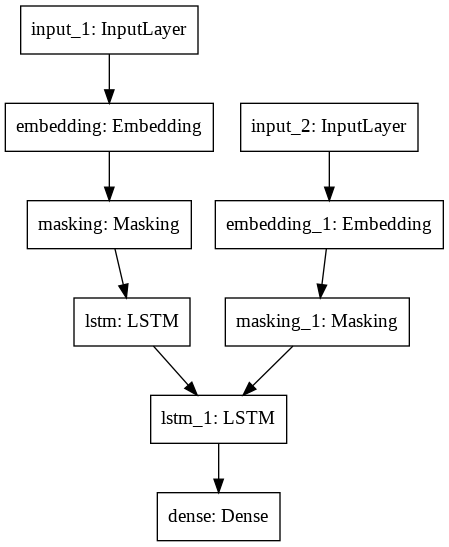

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='rmsprop', metrics=['accuracy'])

In [29]:
history = model.fit(x = [encoder_input_train, decoder_input_train], 
                    y = decoder_target_train, 
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 128, epochs = 50)

Epoch 1/50
233/233 [==============================] - 22s 40ms/step - loss: 4.8180 - accuracy: 0.5993 - val_loss: 1.8824 - val_accuracy: 0.6599
Epoch 2/50
233/233 [==============================] - 7s 31ms/step - loss: 1.7449 - accuracy: 0.7276 - val_loss: 1.5995 - val_accuracy: 0.7446
Epoch 3/50
233/233 [==============================] - 7s 30ms/step - loss: 1.5277 - accuracy: 0.7523 - val_loss: 1.4940 - val_accuracy: 0.7542
Epoch 4/50
233/233 [==============================] - 7s 30ms/step - loss: 1.4328 - accuracy: 0.7626 - val_loss: 1.4280 - val_accuracy: 0.7689
Epoch 5/50
233/233 [==============================] - 7s 31ms/step - loss: 1.3400 - accuracy: 0.7796 - val_loss: 1.3351 - val_accuracy: 0.7863
Epoch 6/50
233/233 [==============================] - 7s 30ms/step - loss: 1.2673 - accuracy: 0.7941 - val_loss: 1.2804 - val_accuracy: 0.7964
Epoch 7/50
233/233 [==============================] - 7s 31ms/step - loss: 1.2072 - accuracy: 0.8037 - val_loss: 1.2276 - val_accuracy: 0.803

## 3. seq2seq 기계 번역기 동작시키기
- seq2seq는 훈련 과정과 테스트 과정에서의 동작 방식이 상이함.
- 테스트 과정을 위해 모델을 다시 설계해주어야 함.

In [30]:
# 인코더
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [31]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [32]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [33]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [34]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [35]:
# 훈련 데이터에 대해서 임의로 선택한 인덱스
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ", seq2src(encoder_input_train[seq_index]))
  print("번역문 :", seq2tar(decoder_input_train[seq_index]))
  print("예측문 :", decoded_sentence[:-5])
  print("\n")

원문 :  i work alone . 
번역문 : je travaille seul . 
예측문 :  je travaille seul . 


원문 :  they have come . 
번역문 : elles sont arrivees . 
예측문 :  ils sont libres . 


원문 :  we re both right . 
번역문 : nous avons toutes deux raison . 
예측문 :  nous nous sommes deux . 


원문 :  how interesting ! 
번역문 : comme c est interessant ! 
예측문 :  comme c est interessant ! 


원문 :  everyone is drunk . 
번역문 : tout le monde est saoul . 
예측문 :  tout le monde est vrai . 




In [36]:
# 테스트 데이터에 대해서 임의로 선택한 인덱스
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ", seq2src(encoder_input_test[seq_index]))
  print("번역문 :", seq2tar(decoder_input_test[seq_index]))
  print("예측문 :", decoded_sentence[:-5])
  print("\n")

원문 :  i never worry . 
번역문 : je ne me fais jamais de souci . 
예측문 :  je ne vous ai jamais fait . 


원문 :  is anybody there ? 
번역문 : quiconque s y trouve t il ? 
예측문 :  quiconque est il la ? 


원문 :  i went on reading . 
번역문 : j ai continue a lire . 
예측문 :  je suis devenu fou . 


원문 :  you had better go . 
번역문 : vous feriez mieux de partir . 
예측문 :  tu es au amie . 


원문 :  they spoke briefly . 
번역문 : ils ont brievement parle . 
예측문 :  ils sont nerveux . 




In [ ]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.dst[seq_index][1:len(lines.dst[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Run!
정답 문장:  Cours ! 
번역기가 번역한 문장:  Faites-le ! 
-----------------------------------
입력 문장: I lied.
정답 문장:  J'ai menti. 
번역기가 번역한 문장:  Je l'ai déjà. 
-----------------------------------
입력 문장: Come in.
정답 문장:  Entre. 
번역기가 번역한 문장:  Reviens ! 
-----------------------------------
입력 문장: Hurry up.
정답 문장:  Magnez-vous ! 
번역기가 번역한 문장:  Dépêchez-vous ! 
-----------------------------------
입력 문장: We walked.
정답 문장:  Nous sommes allées à pied. 
번역기가 번역한 문장:  Nous avons attrapée. 
